## Implementação de um Classificador Perceptron e Multilayer Perceptron

In [4]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Testando o classificador Perceptron

In [5]:
"""Dados de Treinamento """
X = np.array([[1,1],[2,2],[3,3]])
y = np.array([1,1,-1])

"""Criando objeto Perceptron"""
ppn = Perceptron(eta=0.1, n_iter=100)

"""Treinando o modelo"""
ppn.fit(X, y)

"""Testando modelo treinado """
X_newdata = np.array([[4,4],[2,2],[3,3]])
print("Resultado da Predição",ppn.predict(X_newdata));

Resultado da Predição [-1  1 -1]


## Questao 1 - Implementar o modelo Multilayer Perceptron (MLP) e testar este classificador

In [6]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

class MLPClassifier:
    def __init__(self, layer_sizes, learning_rate=0.001, max_iter=1000, random_state=None):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.n_layers = len(layer_sizes)
        
    def _initialize_weights(self, n_features, n_classes):
        np.random.seed(self.random_state)
        self.weights = []
        self.biases = [] 
        
        input_dim = n_features
        for layer_size in self.layer_sizes:
            output_dim = layer_size
            weight = np.random.randn(input_dim, output_dim)
            bias = np.random.randn(output_dim)
            self.weights.append(weight)
            self.biases.append(bias)
            input_dim = output_dim
        
        weight = np.random.randn(input_dim, n_classes)
        bias = np.random.randn(n_classes)
        self.weights.append(weight)
        self.biases.append(bias)
    
    def _forward_pass(self, X):
        self.activations = []
        self.outputs = []
        
        activation = X
        for weight, bias in zip(self.weights[:-1], self.biases[:-1]):
            output = np.dot(activation, weight) + bias
            self.activations.append(output)
            activation = relu(output)
            self.outputs.append(activation)
        
        output = np.dot(activation, self.weights[-1]) + self.biases[-1]
        self.activations.append(output)
        self.outputs.append(softmax(output))
    
    def _backward_pass(self, X, y):
        n_samples = X.shape[0]
        n_classes = self.weights[-1].shape[1]
    
        error = self.outputs[-1] - y
        
        grad = error / n_samples
        
        dW = np.dot(self.outputs[-2].T, grad)
        dB = np.sum(grad, axis=0)  
        
        self.weights[-1] -= self.learning_rate * dW
        self.biases[-1] -= self.learning_rate * dB
        
        for i in range(self.n_layers - 2, -1, -1):
            error = np.dot(grad, self.weights[i + 1].T)
            grad = error * relu_derivative(self.activations[i])
            
            if i > 0:
                dW = np.dot(self.outputs[i - 1].T, grad)
                dB = np.sum(grad, axis=0) 
            else:
                dW = np.dot(X.T, grad)
                dB = np.sum(grad, axis=0)
            
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * dB
    
    def fit(self, X, y):
        n_features = X.shape[1]
        n_classes = y.shape[1]
        
        self._initialize_weights(n_features, n_classes)
        
        for _ in range(self.max_iter):
            self._forward_pass(X)
            self._backward_pass(X, y)
    
    def predict(self, X):
        self._forward_pass(X)
        return self.outputs[-1]


## Questao 2a - Implemente uma função para calcular a acurácia dos modelos

In [7]:
def accuracy_eval(y_true, y_pred):
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    return np.mean(y_true == y_pred)

## Questao 2b - Implemente um método de validação cruzada para testar

In [8]:
def cross_validation(model, X, y, k=5):
    n_samples = X.shape[0]
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)
    scores = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_eval(y_test, y_pred))
    return scores

## Questao 2c - Teste os classificadores usando um conjunto de dados linearmente separável e outro não linearmente separável


#### Conjunto de dados linearmente separaveis


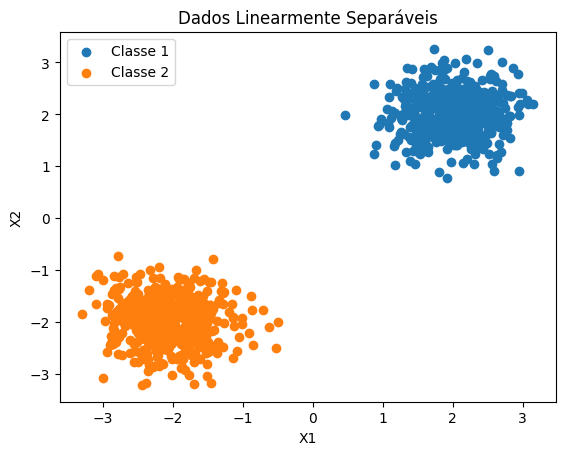

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def generate_linearly_separable_data(num_samples):
    class1_center = np.array([2, 2])
    class1_cov = np.array([[0.2, 0], [0, 0.2]])
    class2_center = np.array([-2, -2])
    class2_cov = np.array([[0.2, 0], [0, 0.2]])

    class1_samples = np.random.multivariate_normal(class1_center, class1_cov, num_samples // 2)
    class1_labels = np.tile([1, 0], (num_samples // 2, 1))


    class2_samples = np.random.multivariate_normal(class2_center, class2_cov, num_samples // 2)
    class2_labels = np.tile([0, 1], (num_samples // 2, 1)) 
    x = np.concatenate((class1_samples, class2_samples), axis=0)
    y = np.concatenate((class1_labels, class2_labels), axis=0)

    indices = np.random.permutation(num_samples)
    x = x[indices]
    y = y[indices]

    return x, y

num_samples = 1000  
x, y = generate_linearly_separable_data(num_samples)

class1_samples = x[y[:, 0] == 1]
class2_samples = x[y[:, 1] == 1]

# Plot dos dados
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], label='Classe 1')
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], label='Classe 2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Dados Linearmente Separáveis')
plt.legend()
plt.show()


In [10]:
# split X, y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
mlp = MLPClassifier(layer_sizes=[10, 10,2], learning_rate=0.01, max_iter=50, random_state=42)

In [12]:
scores = cross_validation(mlp, X_train, y_train, k=5)
print(scores)
errors = mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_eval(y_test, y_pred)
print(accuracy)


[1.0, 1.0, 1.0, 1.0, 1.0]
1.0


#### Conjunto de dados não linearmente separaveis


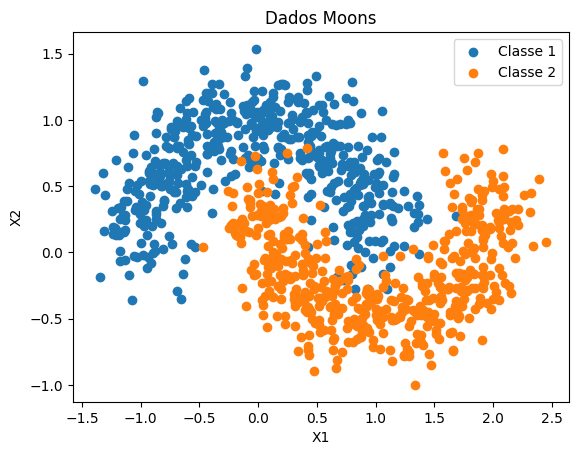

In [13]:

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)


class1_samples = X[y == 0]
class2_samples = X[y == 1]

plt.scatter(class1_samples[:, 0], class1_samples[:, 1], label='Classe 1')
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], label='Classe 2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Dados Moons')
plt.legend()
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train, y_test = np.eye(2)[y_train], np.eye(2)[y_test]

0.955

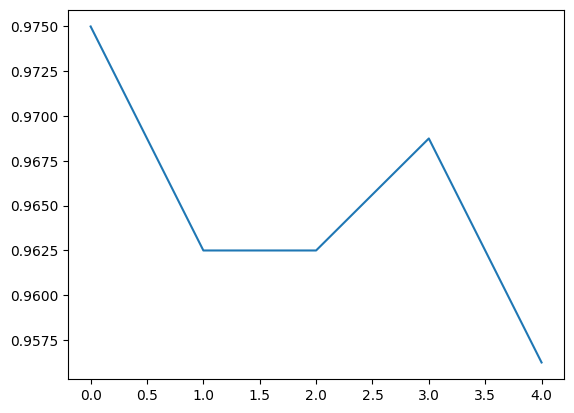

In [17]:
mlp = MLPClassifier(layer_sizes=[50,50,20, 2], learning_rate=0.001, max_iter=1000, random_state=42)
scores = cross_validation(mlp, X_train, y_train, k=5)
# plot cross validation scores
plt.plot(scores)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_eval(y_test, y_pred)
accuracy